In [1]:
import string
import pandas as pd
import numpy as np
import pyphen
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
dic = pyphen.Pyphen(lang='de')
import spacy
nlp = spacy.load("de_core_news_md")
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from src.utils.corpus_manager import DialogueCorpusManager


# Data import

We read the already prepocessed data from 'all_preprocessed.csv'.

In [50]:
full_dataset = DialogueCorpusManager(corpus_file='all_preprocessed.csv', nlp=nlp, build_sentences=True)
df_paragraphs = full_dataset.get_paragraphs()
df_sentences = full_dataset.get_sentences()

# Basic Statistics

We want to gather an overview of the data by giving basic statics.

## On corpus level

First we present information on the entire corpus (all documents).

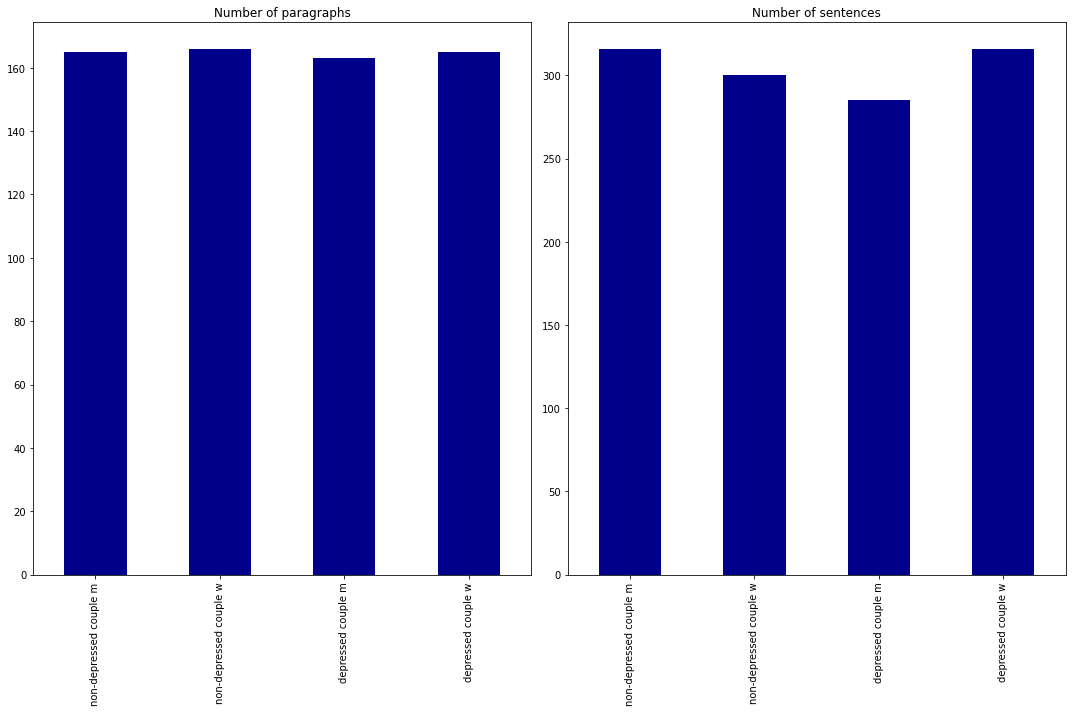

In [319]:
def get_count_per_person_corpus(df):
    df_count_per_person_group0_corpus_speakerM = df.loc[(df['group'] == 0) & (df['gender'] == 'M')].agg('count')
    df_count_per_person_group0_corpus_speakerW = df.loc[(df['group'] == 0) & (df['gender'] == 'W')].agg('count')
    df_count_per_person_group1_corpus_speakerM = df.loc[(df['group'] == 1) & (df['gender'] == 'M')].agg('count')
    df_count_per_person_group1_corpus_speakerW = df.loc[(df['group'] == 1) & (df['gender'] == 'W')].agg('count')

    df_count_per_person_corpus = pd.DataFrame([df_count_per_person_group0_corpus_speakerM['raw_text'], df_count_per_person_group0_corpus_speakerW['raw_text'], df_count_per_person_group1_corpus_speakerM['raw_text'], df_count_per_person_group1_corpus_speakerW['raw_text']]).transpose()
    df_count_per_person_corpus.columns=['non-depressed couple m', 'non-depressed couple w', 'depressed couple m', 'depressed couple w']
    return df_count_per_person_corpus

# Paragraph level
df_count_per_person_corpus_paragraph = get_count_per_person_corpus(df_paragraphs)
# Sentence level
df_count_per_person_corpus_sentence = get_count_per_person_corpus(df_sentences)
# Plot
fig, ax = plt.subplots(1,2, figsize=(15,10))
df_count_per_person_corpus_paragraph.transpose().plot.bar(color='darkblue', legend=False, title='Number of paragraphs', ax=ax[0])
df_count_per_person_corpus_sentence.transpose().plot.bar(color='darkblue', legend=False, title='Number of sentences', ax=ax[1])
plt.tight_layout()


## On transcript a level

We compare the number of paragraphs and sentence the different groups 

In [152]:
df_count_per_person_sentence

,non-depressed couple m,non-depressed couple w,depressed couple m,depressed couple w
0,26,27,38,33
1,48,46,44,57
2,76,52,65,62
3,76,70,69,81
4,90,105,69,83


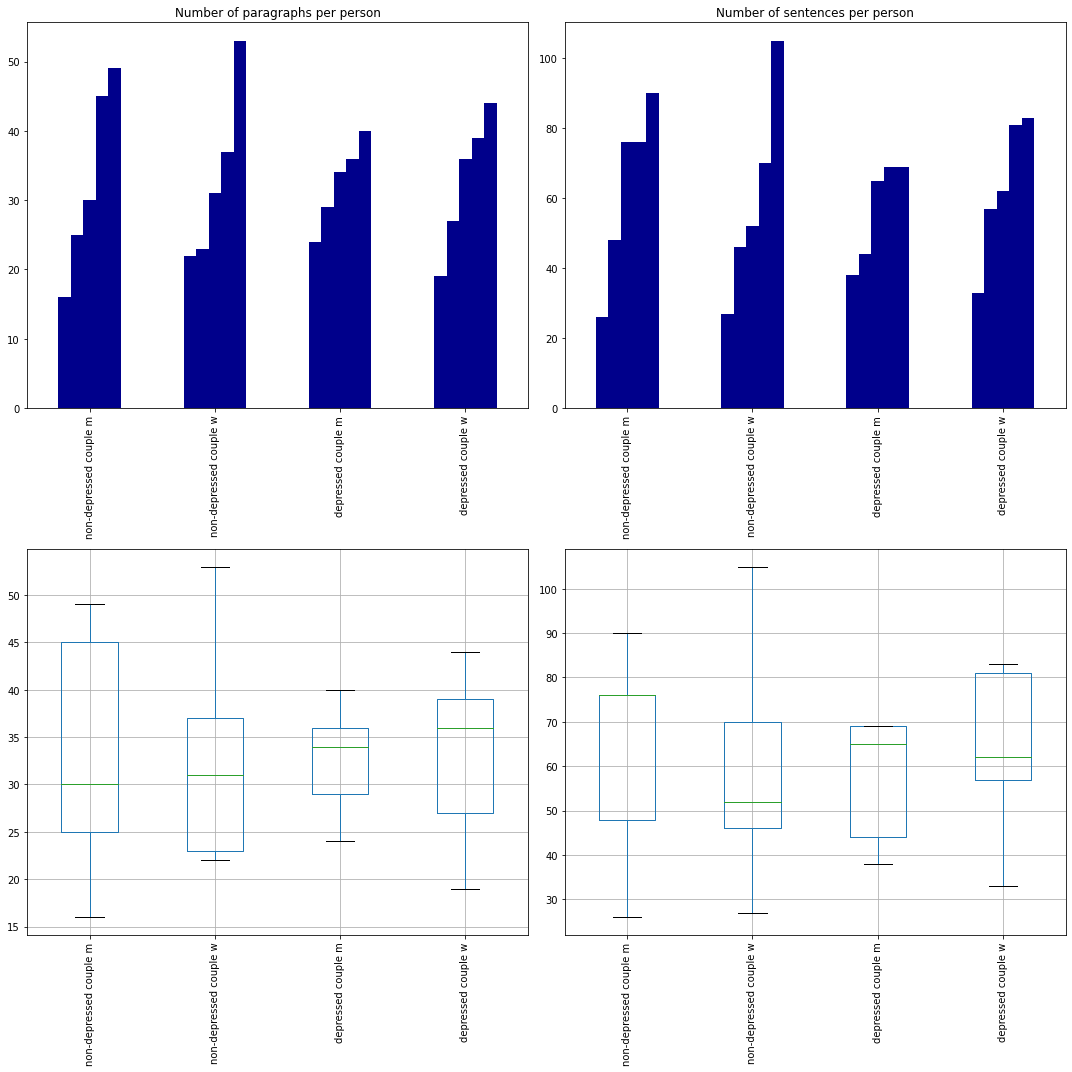

In [321]:
# Method to get the count on a person level for different couples
def get_count_per_person(df):
    df_count_per_person_group0_speakerM = df.loc[(df['group'] == 0) & (df['gender'] == 'M')][['group', 'raw_text', 'couple_id']].groupby(['group', 'couple_id']).agg('count').reset_index()
    df_count_per_person_group0_speakerW = df.loc[(df['group'] == 0) & (df['gender'] == 'W')][['group', 'raw_text', 'couple_id']].groupby(['group', 'couple_id']).agg('count').reset_index()
    df_count_per_person_group1_speakerM = df.loc[(df['group'] == 1) & (df['gender'] == 'M')][['group', 'raw_text', 'couple_id']].groupby(['group', 'couple_id']).agg('count').reset_index()
    df_count_per_person_group1_speakerW = df.loc[(df['group'] == 1) & (df['gender'] == 'W')][['group', 'raw_text', 'couple_id']].groupby(['group', 'couple_id']).agg('count').reset_index()

    df_count_per_person = pd.concat([df_count_per_person_group0_speakerM['raw_text'], df_count_per_person_group0_speakerW['raw_text'], df_count_per_person_group1_speakerM['raw_text'], df_count_per_person_group1_speakerW['raw_text']], axis=1, keys=['non-depressed couple m', 'non-depressed couple w', 'depressed couple m', 'depressed couple w'])
    df_count_per_person_sorted = pd.DataFrame(np.sort(df_count_per_person.values, axis=0), index=df_count_per_person.index, columns=df_count_per_person.columns)
    return df_count_per_person_sorted

# Paragraph level 
df_count_per_person_paragraph = get_count_per_person(df_paragraphs)
# Sentence level
df_count_per_person_sentence = get_count_per_person(df_sentences)
# plot
fig, ax = plt.subplots(2,2, figsize=(15,15))
df_count_per_person_paragraph.transpose().plot.bar(color='darkblue', legend=False, ax=ax[0,0], title='Number of paragraphs per person')
df_count_per_person_sentence.transpose().plot.bar(color='darkblue', legend=False, ax=ax[0,1], title='Number of sentences per person')
df_count_per_person_paragraph.boxplot(rot=90, ax=ax[1,0])
df_count_per_person_sentence.boxplot(rot=90, ax=ax[1,1])
plt.tight_layout()


# TFIDF

### Corpus level - Depressed couples vs. non-depressed couples

Here we compare the TFIDF on the entire corpus comparing all depressed couples with all non-depressed couples.


<AxesSubplot:>

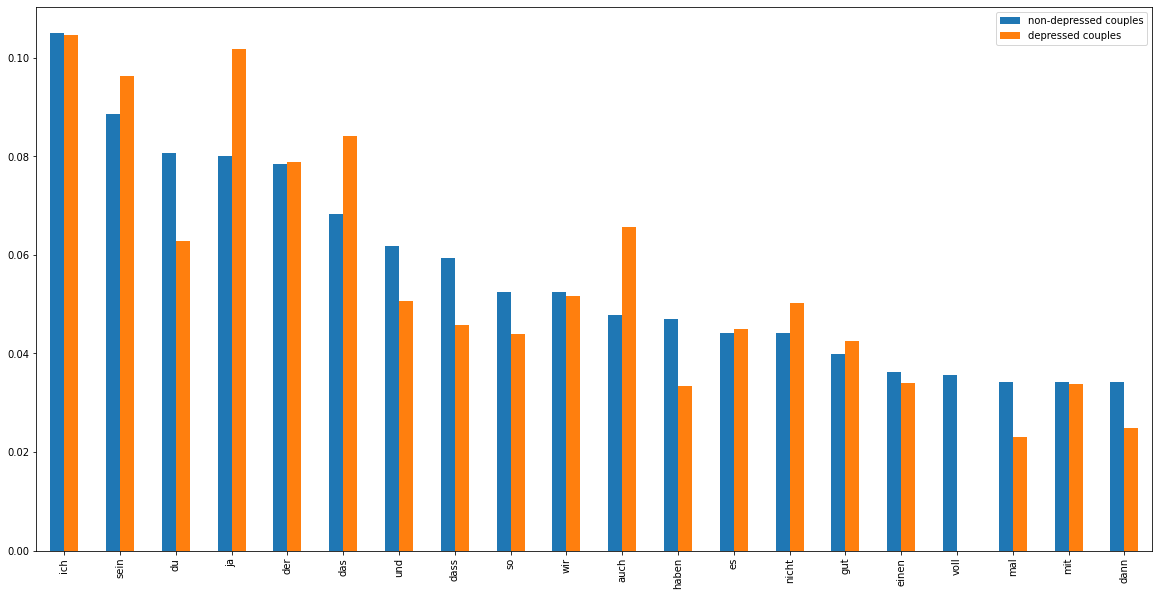

In [114]:
def get_tfidf(dataframe):
    
    # get vectors with frequencies for the words in the lines; each line is considered a document; remove stop words with stop-word-list from scikit-learn; exclude words with frequency smaller 5
    count_vectorizer = CountVectorizer(min_df=5)
    count_vectorized = count_vectorizer.fit_transform(dataframe)

    # transform the vector-frequency matrix in tfidf 
    tfidf_transformer = TfidfTransformer(use_idf=True)
    tfidf = tfidf_transformer.fit_transform(count_vectorized)

    # create new dataframe with tfidfs and the feature names; calculate the mean tfidf over all lines/documents
    df_tfidf = pd.DataFrame(tfidf.T.todense(), index = count_vectorizer.get_feature_names())
    df_tfidf['mean'] = df_tfidf.mean(axis=1)
    df_tfidf = df_tfidf.sort_values('mean', ascending=False)

    return df_tfidf['mean']


non_depressed_couples = df_paragraphs.loc[(df_paragraphs['group'] == 0)]['lemmatized'].dropna()
depressed_couples = df_paragraphs.loc[(df_paragraphs['group'] == 1)]['lemmatized'].dropna()

# get tfidf scores per line
df_tfidf_non_depressed_couples = get_tfidf(non_depressed_couples)
df_tfidf_depressed_couples = get_tfidf(depressed_couples)
df_tfidf = pd.concat([df_tfidf_non_depressed_couples, df_tfidf_depressed_couples], keys=['non-depressed couples', 'depressed couples'], axis=1)
df_tfidf.head(20).plot(kind='bar', figsize=(20,10))

### Corpus level - Depressed persons vs. non-depressed persons

<AxesSubplot:>

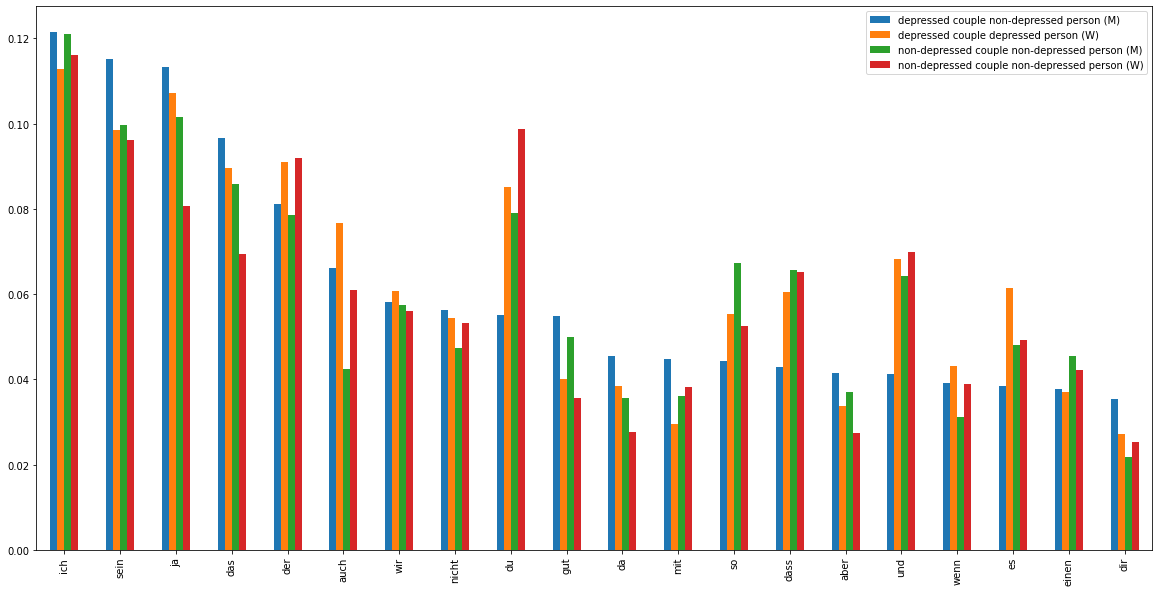

In [116]:

depressed_couple_non_depressed_person = df.loc[(df['group'] == 1) & (df['is_depressed'] == False)]['lemmatized'].dropna()
depressed_couple_depressed_person = df.loc[(df['group'] == 1) & (df['is_depressed'] == True)]['lemmatized'].dropna()
non_depressed_couple_non_depressed_personM = df.loc[(df['group'] == 0) & (df['gender'] == 'M')]['lemmatized'].dropna()
non_depressed_couple_non_depressed_personW = df.loc[(df['group'] == 0) & (df['gender'] == 'W')]['lemmatized'].dropna()

# get tfidf scores per line
df_tfidf_depressed_couple_non_depressed_person = get_tfidf(depressed_couple_non_depressed_person)
df_tfidf_depressed_couple_depressed_person = get_tfidf(depressed_couple_depressed_person)
df_tfidf_non_depressed_couple_non_depressed_personM = get_tfidf(non_depressed_couple_non_depressed_personM)
df_tfidf_non_depressed_couple_non_depressed_personW = get_tfidf(non_depressed_couple_non_depressed_personW)

# plot results
df_tfidf = pd.concat([df_tfidf_depressed_couple_non_depressed_person, df_tfidf_depressed_couple_depressed_person, df_tfidf_non_depressed_couple_non_depressed_personM, df_tfidf_non_depressed_couple_non_depressed_personW], keys=['depressed couple non-depressed person (M)', 'depressed couple depressed person (W)', 'non-depressed couple non-depressed person (M)', 'non-depressed couple non-depressed person (W)'], axis=1)
df_tfidf.head(20).plot(kind='bar', figsize=(20,10))

# POS Tagging

Part-of-speech tagging assigns a grammatical function to every word in the document. We use POS to compare the grammatical structure of the different conversations in order to find differences related to depression.

## Corpus Level (= over all couples)

First we compare the POS on the entire corpus and plot the differences for couples (depressed vs. non-depressed) and persons (depressed person and non-depressed person of a depressed couple as well as both persons from a non-depressed couple).


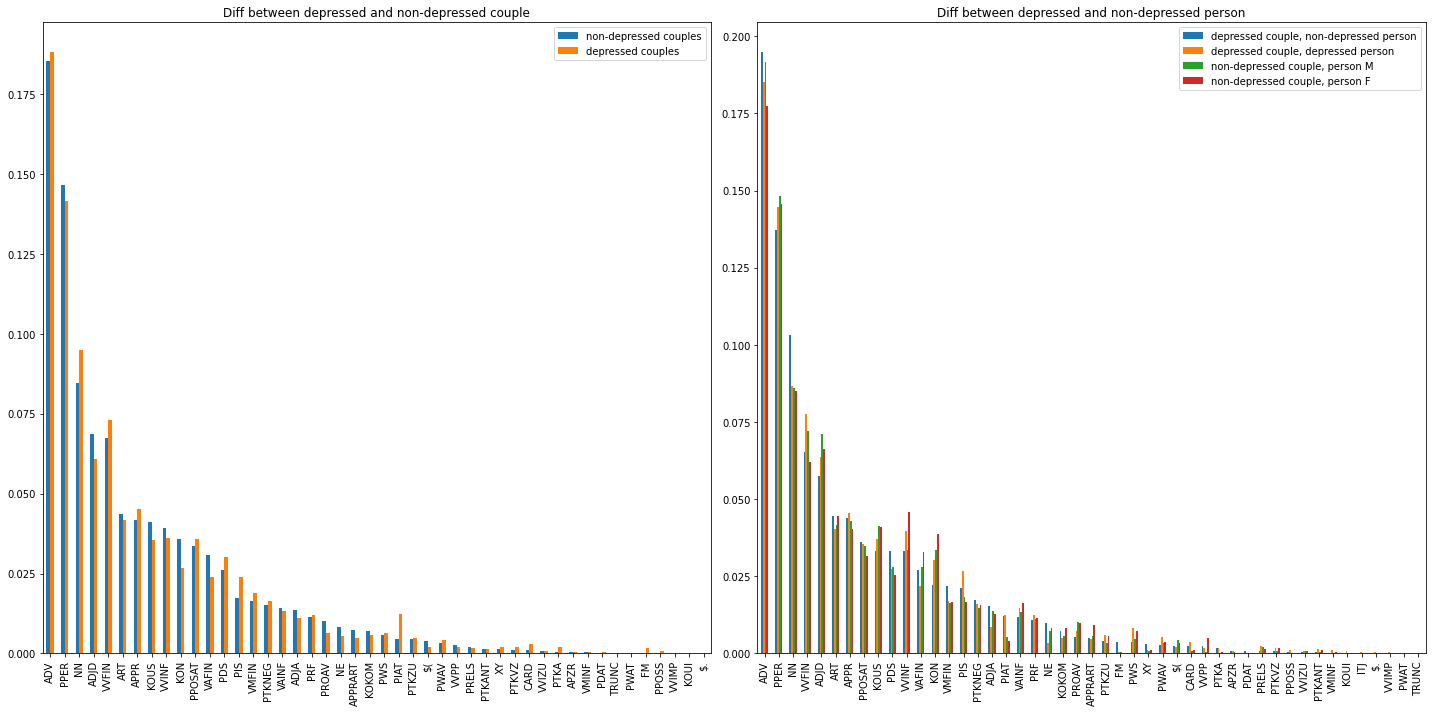

In [298]:
# POS tagging with spacy 
def get_pos(dataframe):
    
    df_as_string = ' '.join(dataframe.tolist())
    
    doc = nlp(df_as_string)
    
    pos = []
    [pos.append(word.tag_) for word in doc]

    return pos

'Depressed couple vs. non-depressed couple'
# get POS for non-depressed couples
non_depressed_couples = df.loc[(df['group'] == 0)]['lemmatized'].dropna()
pos_non_depressed_couples = get_pos(non_depressed_couples)
pos_non_depressed_couples_summary = pd.DataFrame(pos_non_depressed_couples, columns=['non-depressed couples']).apply(pd.value_counts).div(len(pos_non_depressed_couples))

# get POS for depressed couples
depressed_couples = df.loc[(df['group'] == 1)]['lemmatized'].dropna()
pos_depressed_couples = get_pos(depressed_couples)
pos_depressed_couples_summary = pd.DataFrame(pos_depressed_couples, columns=['depressed couples']).apply(pd.value_counts).div(len(pos_depressed_couples))

# summarize in one dataframe 
pos_couples_summary = pd.concat([pos_non_depressed_couples_summary, pos_depressed_couples_summary], axis=1)


'Depressed person vs. non-depressed person'
# get POS for non-depressive person of a depressed couple
depressed_couple_non_depressed_person = df.loc[(df['group'] == 1) & (df['is_depressed'] == False)]['lemmatized'].dropna()
pos_depressed_couple_non_depressed_person = get_pos(depressed_couple_non_depressed_person)
pos_depressed_couple_non_depressed_person_summary = pd.DataFrame(pos_depressed_couple_non_depressed_person, columns=['depressed couple, non-depressed person']).apply(pd.value_counts).div(len(pos_depressed_couple_non_depressed_person))

# get POS for depressed person of a depressed couple
depressed_couple_depressed_person = df.loc[(df['group'] == 1) & (df['is_depressed'] == True)]['lemmatized'].dropna()
pos_depressed_couple_depressed_person = get_pos(depressed_couple_depressed_person)
pos_depressed_couple_depressed_person_summary = pd.DataFrame(pos_depressed_couple_depressed_person, columns=['depressed couple, depressed person']).apply(pd.value_counts).div(len(pos_depressed_couple_depressed_person))

# get POS for non-depressive person of a non-depressed couple
non_depressed_couple_person_M = df.loc[(df['group'] == 0) & (df['gender'] == 'M')]['lemmatized'].dropna()
pos_non_depressed_couple_person_M = get_pos(non_depressed_couple_person_M)
pos_non_depressed_couple_person_M_summary = pd.DataFrame(pos_non_depressed_couple_person_M, columns=['non-depressed couple, person M']).apply(pd.value_counts).div(len(pos_non_depressed_couple_person_M))

non_depressed_couple_person_F = df.loc[(df['group'] == 0) & (df['gender'] == 'W')]['lemmatized'].dropna()
pos_non_depressed_couple_person_F = get_pos(non_depressed_couple_person_F)
pos_non_depressed_couple_person_F_summary = pd.DataFrame(pos_non_depressed_couple_person_F, columns=['non-depressed couple, person F']).apply(pd.value_counts).div(len(pos_non_depressed_couple_person_F))

pos_persons_summary = pd.concat([pos_depressed_couple_non_depressed_person_summary, pos_depressed_couple_depressed_person_summary, pos_non_depressed_couple_person_M_summary, pos_non_depressed_couple_person_F_summary], axis=1)

# plot
fig, ax = plt.subplots(1, 2, figsize=(20,10))
pos_couples_summary.plot.bar(ax=ax[0], title='Diff between depressed and non-depressed couple')

plt.tight_layout()


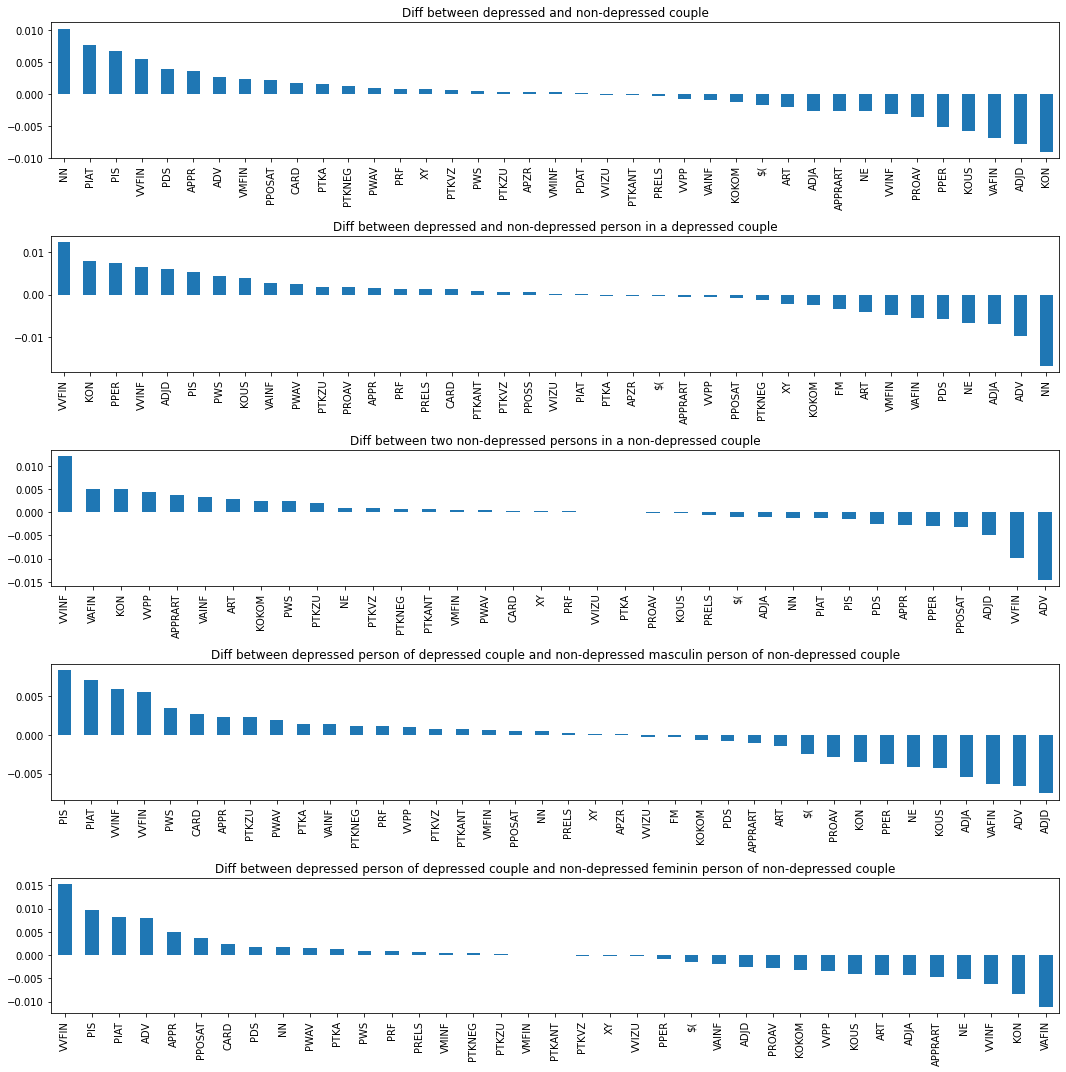

In [317]:
'Check differences for couples'
diff_dc = (pos_depressed_couples_summary.squeeze()-pos_non_depressed_couples_summary.squeeze()).dropna().sort_values(ascending=False)

'Check differences for persons'
# Several comparisons: non-depressed person, depressed person of a depressed couple
diff_dc_dp_ndp =  (pos_depressed_couple_depressed_person_summary.squeeze() - pos_depressed_couple_non_depressed_person_summary.squeeze()).dropna().sort_values(ascending=False)

# Check between both person groups of a non-depressed couple
diff_ndc_pf_pm = (pos_non_depressed_couple_person_F_summary.squeeze() - pos_non_depressed_couple_person_M_summary.squeeze()).dropna().sort_values(ascending=False)

# Check between depressed person of one couple with non-depressed persons of non-depressed couple
diff_dc_dp_ndc_pm = (pos_depressed_couple_depressed_person_summary.squeeze() - pos_non_depressed_couple_person_M_summary.squeeze()).dropna().sort_values(ascending=False)
diff_dc_dp_ndc_pf = (pos_depressed_couple_depressed_person_summary.squeeze() - pos_non_depressed_couple_person_F_summary.squeeze()).dropna().sort_values(ascending=False)

'Plot'
# plot 
fig, ax = plt.subplots(5,1, figsize=(15,15))
diff_dc.plot.bar(ax=ax[0], title='Diff between depressed and non-depressed couple')
diff_dc_dp_ndp.plot.bar(ax=ax[1], title='Diff between depressed and non-depressed person in a depressed couple')
diff_ndc_pf_pm.plot.bar(ax=ax[2], title='Diff between two non-depressed persons in a non-depressed couple')
diff_dc_dp_ndc_pm.plot.bar(ax=ax[3], title='Diff between depressed person of depressed couple and non-depressed masculin person of non-depressed couple')
diff_dc_dp_ndc_pf.plot.bar(ax=ax[4], title='Diff between depressed person of depressed couple and non-depressed feminin person of non-depressed couple')
plt.tight_layout()



## Document level (= compare individual couples)

Secondly we compare the POS between different couples/conversations and plot the differences for couples (depressed vs. non-depressed) and persons (depressed person and non-depressed person of a depressed couple as well as both persons from a non-depressed couple).



In [323]:
couples_ids = df.couple_id.value_counts().index.sort_values().values

depressed_couples = list()
non_depressed_couples = list()

for id in couples_ids:

    # depressed couples -> if depression group
    if(df.loc[(df['couple_id'] == id)]['group'].value_counts().index.values[0] == 1):
        depressed_couple_depressed_person = df.loc[(df['couple_id'] == id) & (df['group'] == 1) & (df['gender'] == 'W')]['lemmatized'].dropna().tolist()
        depressed_couple_depressed_person_string = ' '.join(depressed_couple_depressed_person)
        
        depressed_couple_non_depressed_person = df.loc[(df['couple_id'] == id) & (df['group'] == 1) & (df['gender'] == 'M')]['lemmatized'].dropna().tolist()
        depressed_couple_non_depressed_person_string = ' '.join(depressed_couple_non_depressed_person)

        doc_depressed_couple_depressed_person = nlp(depressed_couple_depressed_person_string)
        doc_depressed_couple_non_depressed_person = nlp(depressed_couple_non_depressed_person_string)

        pos_depressed_couple_depressed_person = []
        [pos_depressed_couple_depressed_person.append(doc.tag_) for doc in doc_depressed_couple_depressed_person]

        pos_depressed_couple_non_depressed_person = []
        [pos_depressed_couple_non_depressed_person.append(doc.tag_) for doc in doc_depressed_couple_non_depressed_person]

        pos_depressed_couple_depressed_person_summary = pd.DataFrame(pos_depressed_couple_depressed_person, columns=['depressed couple, depressed person']).apply(pd.value_counts).div(len(pos_depressed_couple_depressed_person))
        pos_depressed_couple_non_depressed_person_summary = pd.DataFrame(pos_depressed_couple_non_depressed_person, columns=['depressed couple, non-depressed person']).apply(pd.value_counts).div(len(pos_depressed_couple_non_depressed_person))
        pos_summary = pd.concat([pos_depressed_couple_depressed_person_summary, pos_depressed_couple_non_depressed_person_summary], axis=1)
            
        depressed_couples.append((id, pos_summary))

    # non-depressed couples
    elif(df.loc[(df['couple_id'] == id)]['group'].value_counts().index.values[0] == 0):
        non_depressed_couple_person1 = df.loc[(df['couple_id'] == id) & (df['group'] == 0) & (df['gender'] == 'W')]['lemmatized'].dropna().tolist()
        non_depressed_couple_person1_string = ' '.join(non_depressed_couple_person1)
        
        non_depressed_couple_person2 = df.loc[(df['couple_id'] == id) & (df['group'] == 0) & (df['gender'] == 'M')]['lemmatized'].dropna().tolist()
        non_depressed_couple_person2_string = ' '.join(non_depressed_couple_person2)

        doc_non_depressed_couple_person1 = nlp(non_depressed_couple_person1_string)
        doc_non_depressed_couple_person2 = nlp(non_depressed_couple_person2_string)

        pos_non_depressed_couple_person1= []
        [pos_non_depressed_couple_person1.append(doc.tag_) for doc in doc_non_depressed_couple_person1]

        pos_non_depressed_couple_person2 = []
        [pos_non_depressed_couple_person2.append(doc.tag_) for doc in doc_non_depressed_couple_person2]

        pos_non_depressed_couple_person1_summary = pd.DataFrame(pos_non_depressed_couple_person1, columns=['non-depressed couple, person 1']).apply(pd.value_counts).div(len(pos_non_depressed_couple_person1))
        pos_non_depressed_couple_person2_summary = pd.DataFrame(pos_non_depressed_couple_person2, columns=['non-depressed couple, person 2']).apply(pd.value_counts).div(len(pos_non_depressed_couple_person2))
        pos_summary = pd.concat([pos_non_depressed_couple_person1_summary, pos_non_depressed_couple_person2_summary], axis=1)
            
        non_depressed_couples.append((id, pos_summary))



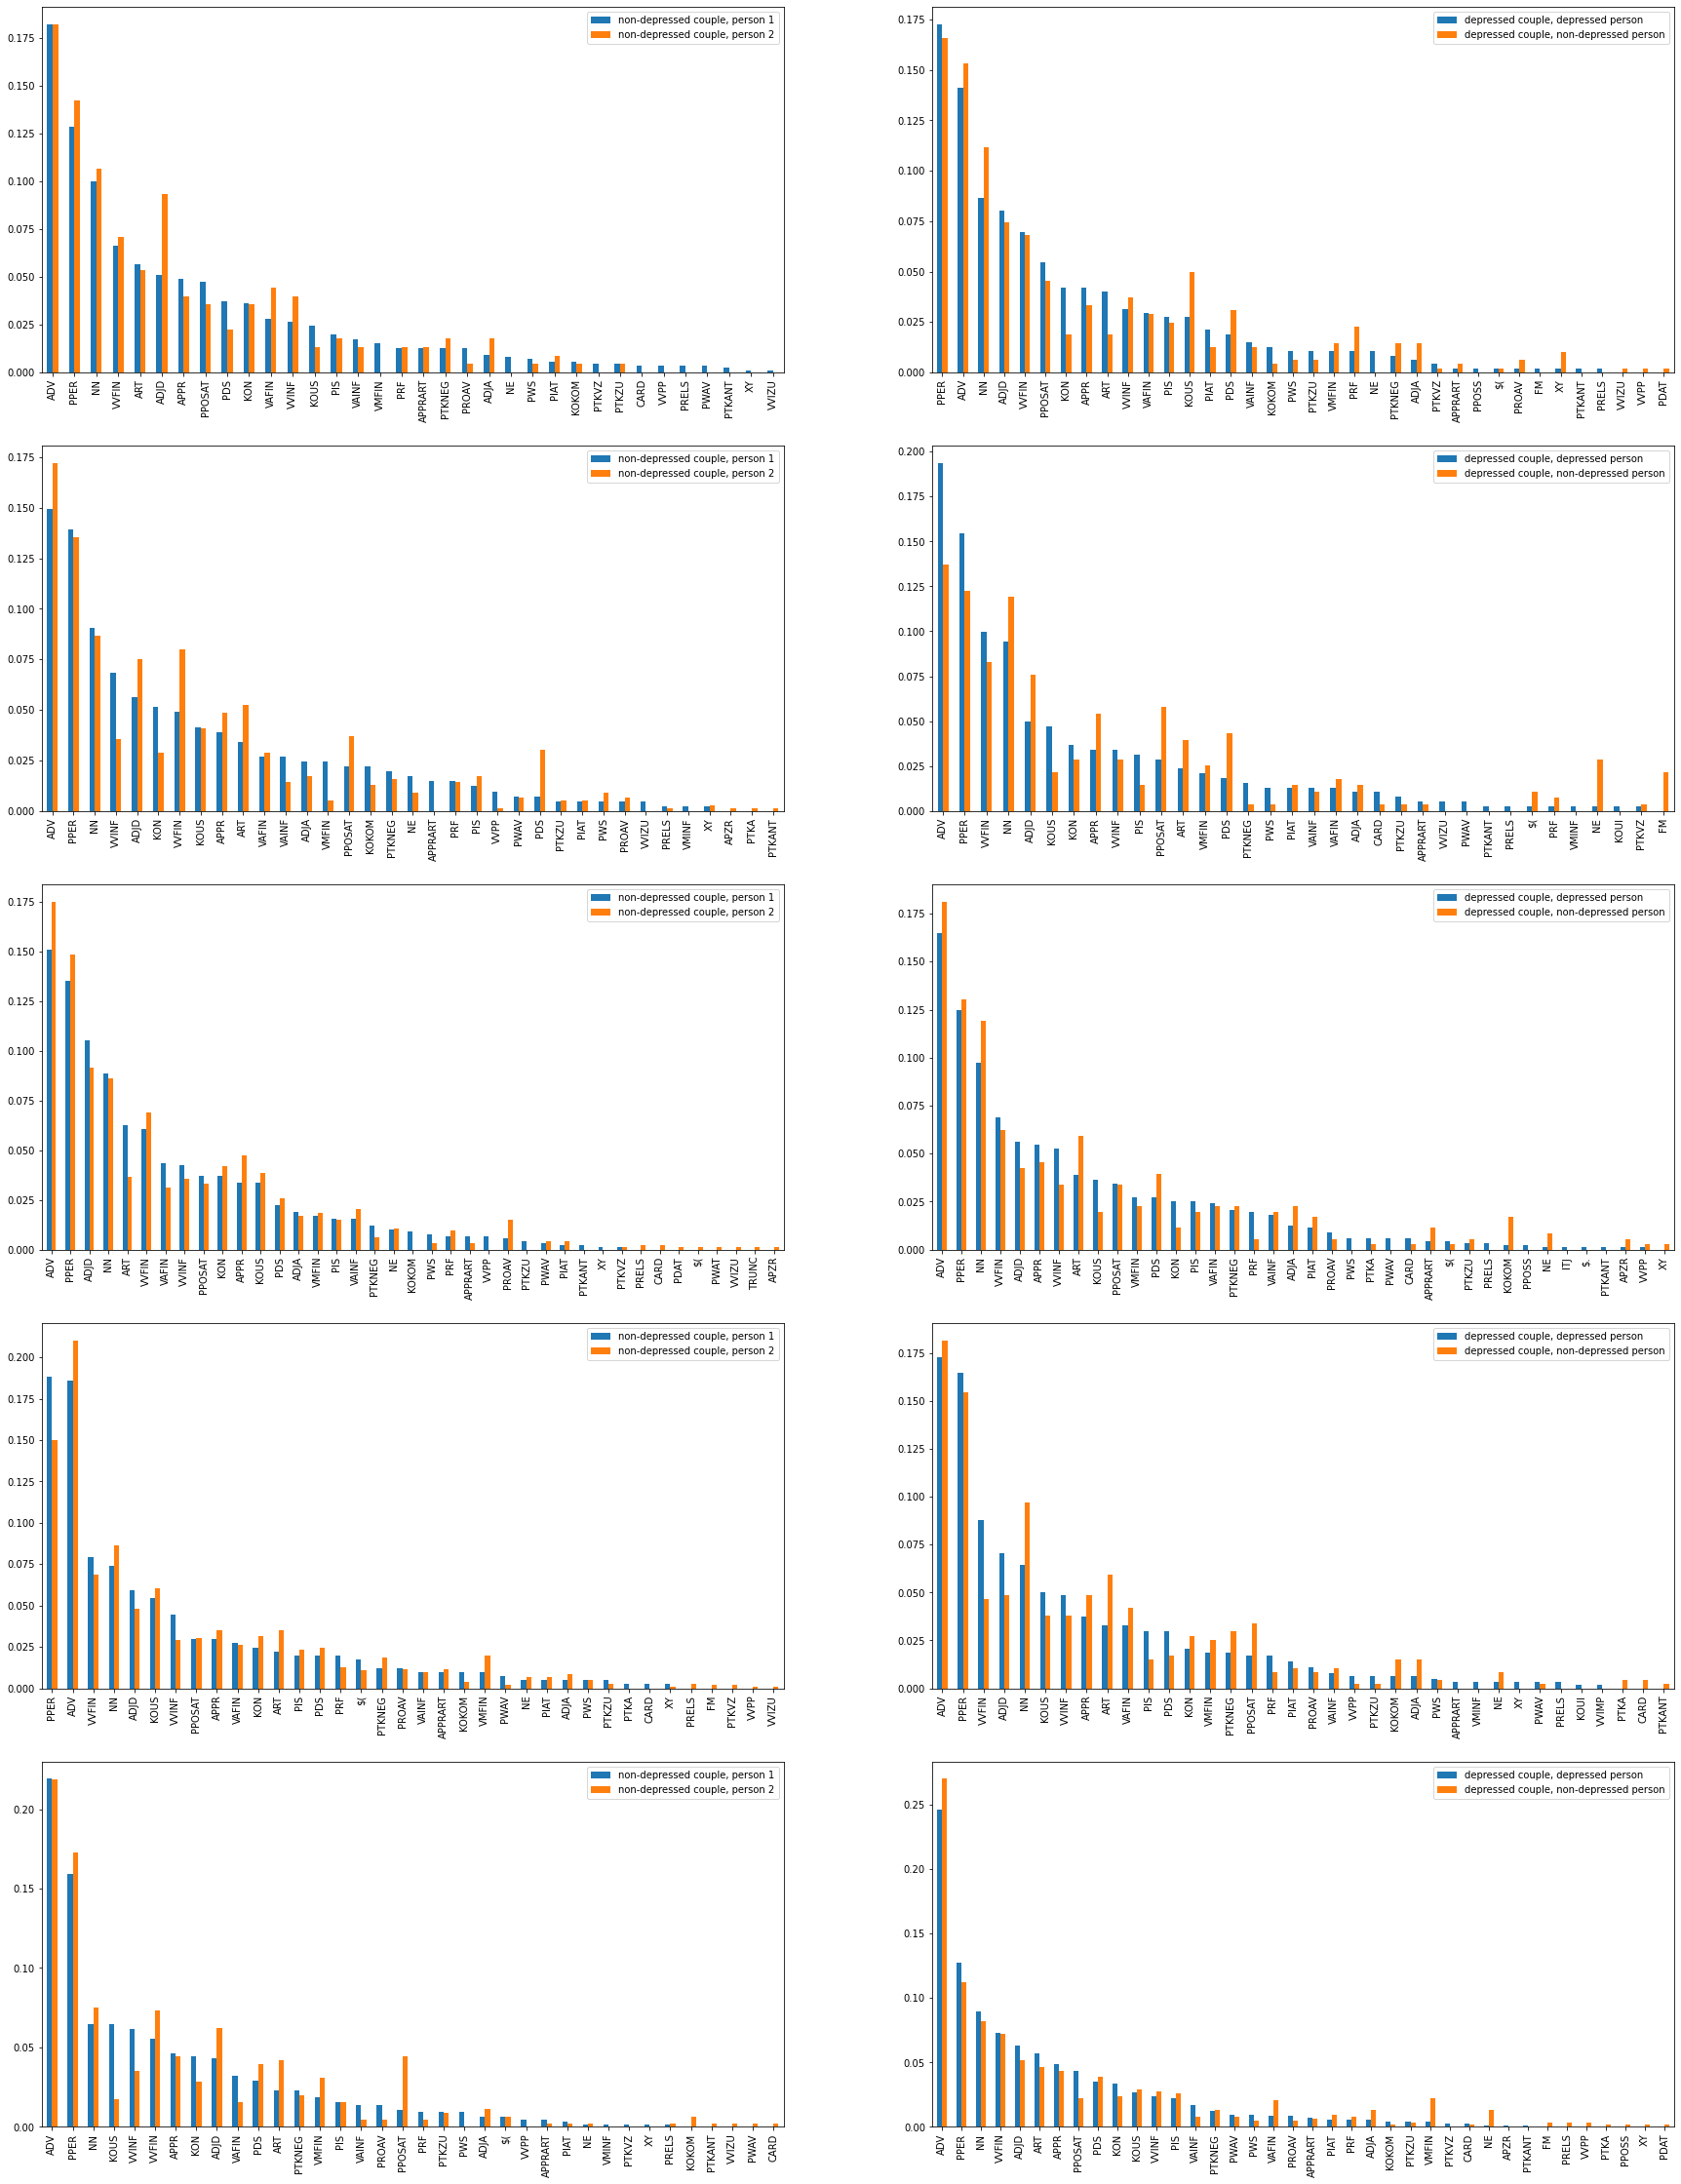

In [324]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(30, 40))

for i in range(len(non_depressed_couples)):
    non_depressed_couples[i][1].plot(kind='bar', ax=axes[i,0])
for i in range(len(depressed_couples)):
    depressed_couples[i][1].plot(kind='bar', ax=axes[i,1])

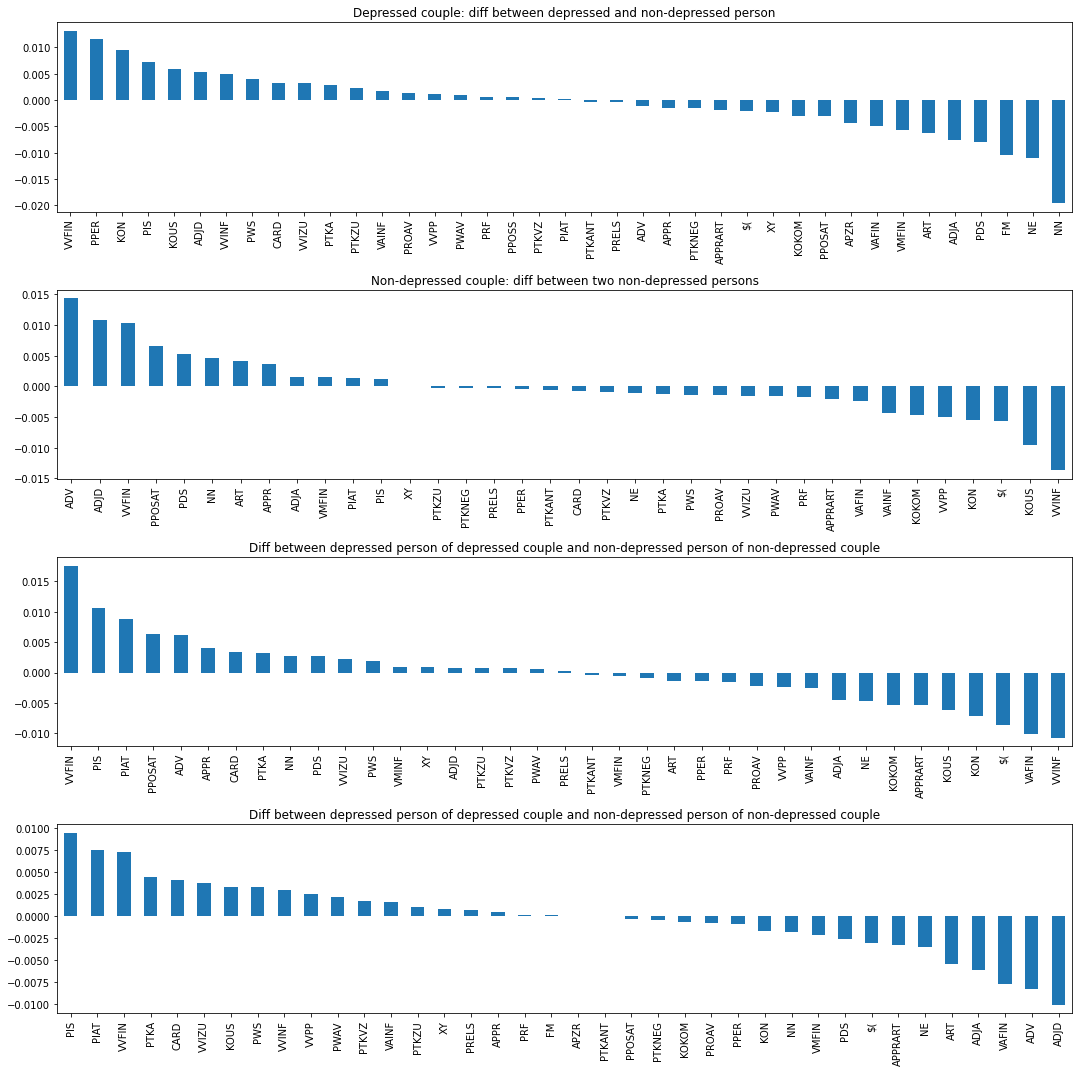

In [281]:
# POS of all depressed/non-depressed couples in one dataframe 
all_depressed_couples = pd.concat([depressed_couples[0][1], depressed_couples[1][1], depressed_couples[2][1],  depressed_couples[3][1], depressed_couples[4][1]], axis=1, keys=['couple1', 'couple2', 'couple3', 'couple4', 'couple5'])

all_non_depressed_couples = pd.concat([non_depressed_couples[0][1], non_depressed_couples[1][1], non_depressed_couples[2][1], non_depressed_couples[3][1], non_depressed_couples[4][1]], axis=1, keys=['couple1', 'couple2', 'couple3', 'couple4', 'couple5'])

# Order by person
all_depressed_couples_all_depressed_persons = pd.DataFrame([all_depressed_couples['couple1']['depressed couple, depressed person'], all_depressed_couples['couple2']['depressed couple, depressed person'], all_depressed_couples['couple3']['depressed couple, depressed person'], all_depressed_couples['couple4']['depressed couple, depressed person'], all_depressed_couples['couple5']['depressed couple, depressed person']]).transpose()

all_depressed_couples_all_non_depressed_persons = pd.DataFrame([all_depressed_couples['couple1']['depressed couple, non-depressed person'], all_depressed_couples['couple2']['depressed couple, non-depressed person'], all_depressed_couples['couple3']['depressed couple, non-depressed person'], all_depressed_couples['couple4']['depressed couple, non-depressed person'], all_depressed_couples['couple5']['depressed couple, non-depressed person']]).transpose()

all_depressed_couples_all_Mpersons = pd.DataFrame([all_non_depressed_couples['couple1']['non-depressed couple, person 1'], all_non_depressed_couples['couple2']['non-depressed couple, person 1'], all_non_depressed_couples['couple3']['non-depressed couple, person 1'], all_non_depressed_couples['couple4']['non-depressed couple, person 1'], all_non_depressed_couples['couple5']['non-depressed couple, person 1']]).transpose()

all_depressed_couples_all_Wpersons = pd.DataFrame([all_non_depressed_couples['couple1']['non-depressed couple, person 2'], all_non_depressed_couples['couple2']['non-depressed couple, person 2'], all_non_depressed_couples['couple3']['non-depressed couple, person 2'], all_non_depressed_couples['couple4']['non-depressed couple, person 2'], all_non_depressed_couples['couple5']['non-depressed couple, person 2']]).transpose()

'Calculate mean'
mean_adcadp = all_depressed_couples_all_depressed_persons.mean(axis=1)
mean_adcandp = all_depressed_couples_all_non_depressed_persons.mean(axis=1)
mean_andcaMp = all_depressed_couples_all_Mpersons.mean(axis=1)
mean_andcaWp = all_depressed_couples_all_Wpersons.mean(axis=1)

var_adcadp = all_depressed_couples_all_depressed_persons.var(axis=1)
var_adcandp = all_depressed_couples_all_non_depressed_persons.var(axis=1)
var_andcaMp = all_depressed_couples_all_Mpersons.var(axis=1)
var_andcaWp = all_depressed_couples_all_Wpersons.var(axis=1)


# Several comparisons: non-depressed person, depressed person of a depressed couple
meandiff_depressed_couple = (mean_adcadp-mean_adcandp).dropna().sort_values(ascending=False)
vardiff_depressed_couple = (var_adcadp-var_adcandp).dropna().sort_values(ascending=False)

# Check between both person groups of a non-depressed couple
meandiff_non_depressed_couple = (mean_andcaWp-mean_andcaMp).dropna().sort_values(ascending=False)
vardiff_non_depressed_couple = (var_andcaWp-var_andcaMp).dropna().sort_values(ascending=False)

# Check between depressed person of one couple with non-depressed persons of non-depressed couple
meandiff_depressed_couple_depressed_person_non_depressed_couple_Mperson = (mean_adcadp-mean_andcaMp).dropna().sort_values(ascending=False)
meandiff_depressed_couple_depressed_person_non_depressed_couple_Fperson = (mean_adcadp-mean_andcaWp).dropna().sort_values(ascending=False)

# plot 
fig, ax = plt.subplots(4,1, figsize=(15,15))
meandiff_depressed_couple.plot.bar(ax=ax[0], title='Diff between depressed and non-depressed person in a depressed couple')
meandiff_non_depressed_couple.plot.bar(ax=ax[1], title='Diff between two non-depressed persons in a non-depressed couple')
meandiff_depressed_couple_depressed_person_non_depressed_couple_Mperson.plot.bar(ax=ax[2], title='Diff between depressed person of depressed couple and non-depressed person of non-depressed couple')
meandiff_depressed_couple_depressed_person_non_depressed_couple_Fperson.plot.bar(ax=ax[3], title='Diff between depressed person of depressed couple and non-depressed person of non-depressed couple')
plt.tight_layout()


## Results

Following POS tags can be tested as features for the classification: 

* Depressed person
    * VVFIN = finite verb, full
    * PIS = substituting indefinite pronoun

* Non-depressed person 
    * ADJA = adjective attributive 
    * ART = definite or indefinite article
    * VAFIN = finite verb, auxilliary
    * (VMFIN = finite verb, modal)
    * (NN = noun)
    * (NE = proper noun)
    * (FM = foreing language material)
    * (PDS = substituting demonstrative pronoun)
    * (APZR = circumposition right)
